In [509]:
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
import glob
import matplotlib.pyplot as plt

In [510]:
# Define the constants
S = 7 # Divide the image to have S*S cells
C = 1 # Number of classes 
B = 2 # Number of bounding boxes to be predicted per cell

In [511]:
# Import image paths
imagesRaw = glob.glob("./new_images/*.jpg")
imagesRaw.sort()

In [512]:
# Grab all the bounding box info
with open('boundingBoxes.txt', 'r') as f:
    lines = f.readlines()
 
boxes = [[float(x) for x in line.strip().split(",")] for line in lines]

In [513]:
# Create a new dataset, pairing images and respective boxes
imageDataSet = tf.data.Dataset.from_tensor_slices((imagesRaw, boxes))
# Shuffle the data
imageDataSet = imageDataSet.shuffle(100)

In [514]:
def load_jpeg(image, box):
    # Load the image turn into jpeg
    decoded = tf.io.read_file(image)
    imageTf = tf.image.decode_jpeg(decoded)
    # Normalize the images
    returnImage = tf.cast(imageTf, tf.float32) / 255.0
    returnImage = tf.reshape(returnImage, (488,488,3))
    return returnImage, box

# Plots two given images
def display(imageOne, imageTwo):
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imageOne))
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imageTwo))
    plt.axis("off")
    plt.show()

# Convert the yolo box format to tensor box format
def convertYolo(box):
    xMax = box[0]*488*2
    yMax = box[1]*488*2
    xMin = - box[2]*488 + xMax
    yMin = - box[3]*488 + yMax
    return xMax, yMax, xMin, yMin

In [515]:
# Convert the paths into actual images
entireSet = imageDataSet.map(load_jpeg)

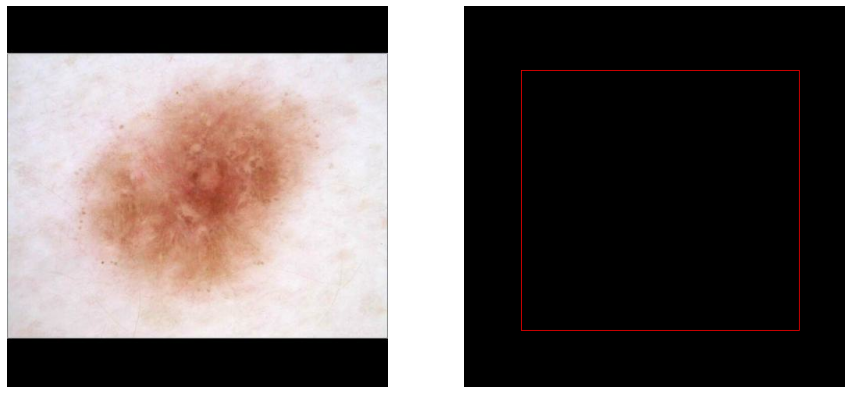

In [516]:
# Ensure the bounding boxes match the images
for image, box in entireSet.take(1):
    xMax, yMax, xMin, yMin = convertYolo(box)
    #Convert image to float32 (required for draw_bounding_boxes)
    boxImage = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Reshape to [batch, height, width, depth]
    boxImage = tf.reshape(boxImage, shape=[1, 488, 488, 3])
    box = tf.stack([yMin/488, xMin/488, yMax/488, xMax/488], axis=0)
    # Reshape to [batch, num_bounding_boxes, 4]
    box = tf.reshape(box, shape=[1,1,4])
    colors = [[255.0, 0.0, 1.0]]
    newImage = tf.image.draw_bounding_boxes(boxImage, box, colors)
    display(image, newImage.numpy()[0])

In [517]:
# Divide the dataset into train, test and validation
trainSize = int(0.8 * 2594)
valSize = int(0.1 * 2594)
train = entireSet.take(trainSize)
temp = entireSet.skip(trainSize)
test = temp.skip(valSize)
validation = temp.take(valSize)

In [518]:
tf.print(test)
# Create batches:
train_batches = train.batch(1)
test_batches = test.batch(1)
validation_batches = validation.batch(1)
print(train_batches)
print(test_batches)
print(validation_batches)

<SkipDataset shapes: ((488, 488, 3), (5,)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 488, 488, 3), (None, 5)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 488, 488, 3), (None, 5)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 488, 488, 3), (None, 5)), types: (tf.float32, tf.float32)>


In [519]:
model = tf.keras.Sequential([
    #First Layer
    tf.keras.layers.Conv2D(64, (7,7), strides=(2, 2), activation=LeakyReLU(alpha=0.1),  input_shape=(488,488,3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    #Second Layer
    tf.keras.layers.Conv2D(192, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    #Third Layer
    tf.keras.layers.Conv2D(128, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(256, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(256, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    #Fourth Layer
    # +++ Repeated block
    tf.keras.layers.Conv2D(256, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    
    tf.keras.layers.Conv2D(256, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),

    tf.keras.layers.Conv2D(256, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),

    tf.keras.layers.Conv2D(256, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    # +++ END BLOCK
    tf.keras.layers.Conv2D(512, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    #Fifth layer
    # +++ Repeated Block
    tf.keras.layers.Conv2D(512, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    
    tf.keras.layers.Conv2D(512, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    # +++ END BLOCK
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), strides=(2, 2), activation=LeakyReLU(alpha=0.1), padding="same"),
    
    #Sixth Layer
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    

    # Final Output Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation=LeakyReLU(alpha=0.1)),
    tf.keras.layers.Dense(S * S * (B*5+C), input_shape=(4096,), activation="sigmoid"),
    tf.keras.layers.Reshape(target_shape = (S, S, (B*5+C)))
    
])

The yoloLoss function is an adpation from here: https://blog.emmanuelcaradec.com/humble-yolo-implementation-in-keras/. All credit goes to Emmanuel Caradec

In [520]:
def yoloLoss(y_true, y_pred):
    grid = [[[float(x),float(y)]]*B for y in range(S) for x in range(S)]
    
    pred_boxes = tf.reshape(y_pred[...,3:], (-1,S*S,B,5))
    # Reshape the 3: too S*S, B, 5 i.e. 49, 2, 5. 
    # Each cell has two bounding boxes, with each bounding box, having 5 elements. 
    
    y_true_conf = y_true[...,4]
    y_pred_conf = pred_boxes[...,4]
    
    y_pred_wh   = pred_boxes[...,2:4]
    y_true_wh   = y_true[...,2:4]
    # y_pred_wh. Shape (S*S,B,2). Where each cell, has B bounding boxes, with each
    # Bounding box having two rows?

    y_pred_xy   = pred_boxes[...,0:2] + grid
    y_true_xy   = y_true[...,0:2]
    # The y_true_xy will have a shape of S*S, B, 2. Where each cell, has B bounding boxes, with two colums? 
    # I understand grabbing the xy pairs, but why + the grid?
    
    y_true_class = 0
    y_pred_class = y_pred[...,0:2]
    
    
    # Losses Calculations +++++++++++++++++++++++++++++++++++++++++++++++++++
    

    xy_loss    = tf.math.reduce_sum(tf.math.reduce_sum(tf.math.square(y_true_xy - y_pred_xy),
                                                       axis=-1)*y_true_conf, axis=-1)
    # Two reduce sums  = 2 summations. Axis = -1, along last dimensions i.e. columns/entries in this case.
    # Square is element wise. y_true_conf is the little 1, in the formula. 

    wh_loss    = tf.math.reduce_sum(tf.math.reduce_sum(tf.math.square(tf.math.sqrt(y_true_wh) - 
                                                                      tf.math.sqrt(y_pred_wh)), axis=-1)
                                    *y_true_conf, axis=-1)
    # Two reduce sums  = 2 summations. Axis = -1, along last dimensions i.e. rows in this case
    # Makes sense, matches formula. 
    
    clss_loss  = tf.math.reduce_sum(tf.math.square(y_true_class - y_pred_class)*y_true_conf, axis=-1)
    # Needs to be reshaped. 
    clss_loss = tf.reshape(clss_loss, [-1, 49])
    
                                    
    intersect_wh = tf.math.maximum(tf.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 
                                   - tf.math.abs(y_pred_xy - y_true_xy) )
    
    
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area

    conf_loss = tf.math.reduce_sum(tf.math.square(y_true_conf*iou - y_pred_conf)*y_true_conf, axis=-1)
    
    loss =  clss_loss + xy_loss + wh_loss + conf_loss
                                    
    return loss

# Mean average position

In [521]:
# Implement custom metric: Jaccard 
def jaccardIndex(y_true, y_pred):
    # Format the y_true to be of the correct shape:
    zeros = tf.zeros([S, S, B*5+C])
    y_true = zeros + tf.reshape(y_true, (-1,11))
    # Computes the element wise multiplication then summation. i.e. calculate the area that overlaps
    numerator = (tf.math.reduce_sum(tf.math.multiply(y_true, y_pred)))
    # Calculate the area of both - area that overlaps
    denom = tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_true) - numerator
    return numerator/denom

In [522]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=yoloLoss,
              metrics=[jaccardIndex])

In [523]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_360 (Conv2D)          (None, 241, 241, 64)      9472      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_361 (Conv2D)          (None, 120, 120, 192)     110784    
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 60, 60, 192)       0         
_________________________________________________________________
conv2d_362 (Conv2D)          (None, 60, 60, 128)       24704     
_________________________________________________________________
conv2d_363 (Conv2D)          (None, 60, 60, 256)       295168    
_________________________________________________________________
conv2d_364 (Conv2D)          (None, 60, 60, 256)     

In [524]:
history =  model.fit(train_batches, epochs=1, validation_data=validation_batches)

InvalidArgumentError:  Input to reshape is a tensor with 5 values, but the requested shape requires a multiple of 11
	 [[node Reshape (defined at \AppData\Local\Temp/ipykernel_14056/839523676.py:5) ]] [Op:__inference_train_function_134233]

Errors may have originated from an input operation.
Input Source operations connected to node Reshape:
 IteratorGetNext (defined at \AppData\Local\Temp/ipykernel_14056/3803976030.py:1)

Function call stack:
train_function
